### Imports

In [19]:
import operator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import rfpimp
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import feature_selection
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, Imputer, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
%matplotlib inline
# %load_ext autoreload
# %autoreload 2

### Aux Functions

In [20]:
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]
    
    
def univariate_auc(dataset, variable_name):
    sorted_dataset = dataset[[variable_name, "TYPE"]].sort_values(by=variable_name).dropna()
    fpr, tpr, _ = roc_curve(le.fit_transform(sorted_dataset.TYPE), sorted_dataset[[variable_name]])
    return auc(fpr, tpr)

def balanced_accuracy(dataset, variable_name):
    tp = dataset[(dataset.TYPE == "Pathogenic") & dataset[variable_name]].shape[0]
    p = dataset[dataset.TYPE == "Pathogenic"].shape[0]
    tn = dataset[(dataset.TYPE == "Benign") & (~dataset[variable_name])].shape[0]
    n = dataset[dataset.TYPE == "Benign"].shape[0]
    return (tp/p + tn/n) / 2

In [21]:
for variable in cont_vars:
    print(variable, ":", univariate_auc(varq, variable))

SASA : 0.34141093759980334
BFACTOR : 0.45893877338986594
SWITCHBILITY : 0.4988704594020753
AGGREGABILITY : 0.5127936444721555
CONSERVATION : 0.4354685245310245
VARIATION_ENERGY : 0.6836003366726937


In [22]:
for variable in cat_vars:
    print(variable, ":", balanced_accuracy(varq, variable))

PDB : 0.4941370219957124
3DID : 0.519917841948809


### Analysis

In [76]:
# varq = pd.read_csv("../data/processed/properties-varq.tab.gz", sep="\t", index_col="MUTANT")
# varq = pd.read_csv("../data/processed/humsavar_varq_gt.csv.gz", sep=",", index_col="MUTANT").drop("dbSNP", 1)
varq = pd.read_csv("../data/processed/varq/varq_clean.csv.gz", index_col="MUTANT")
varq = varq[varq.TYPE != "Unclassified"].drop(["ACTIVE_SITE"], 1)
# varq['random'] = np.random.random(size=len(varq))


In [77]:
varq.to_csv("../data/processed/varq/dataset.csv.gz", compression="gzip", index=True, index_label="MUTANT")

In [78]:
varq.columns

Index(['SASA', 'SASA_PERCENTAGE', 'BFACTOR', 'SWITCHBILITY', 'AGGREGABILITY',
       'CONSERVATION', '3DID', 'PDB', 'VARIATION_ENERGY', 'TYPE'],
      dtype='object')

In [79]:
varq.index.unique().shape

(7418,)

In [80]:
varq.TYPE.value_counts()

Pathogenic    5377
Benign        2041
Name: TYPE, dtype: int64

### Machine Learning

In [81]:
# feature_union = 
cat_vars = ["PDB", "3DID"]
cont_vars = varq.columns[~varq.columns.isin(cat_vars + ["TYPE"])].tolist()



impute = ('union', 
          FeatureUnion(
              transformer_list=[
                  ('continuous', Pipeline([
                      ('selector', ItemSelector(key=cont_vars)),
                      ('imputer', Imputer(missing_values="NaN", strategy="median"))
                  ])),
                  ('categorical', Pipeline([
                      ('selector', ItemSelector(key=cat_vars)),
                      ('imputer', Imputer(missing_values="NaN", strategy="most_frequent"))
                      
                  ]))
              ]))
                  
    
scale = ('scaler', RobustScaler())

model_dict = {
    'lr':{'pipe':[impute, scale, ('lr', LogisticRegression())],
        'params':[{'lr__C' : [.001, .01, .1, 1, 10, 100, 1000], 'lr__class_weight':[None, 'balanced']}],
        'name':'LogisticRegression'
    },
    'rf':{'pipe':[impute, ('rf', RandomForestClassifier(random_state = 100, oob_score=False))],
        'params':[{'rf__max_depth':[3,5,7], 'rf__n_estimators':[10,50,100], 'rf__max_features':[4,'sqrt',0.2]}],
        'name':'Random Forest'
    },
    'svc':{'pipe': [impute, scale, ('svc', SVC(kernel='rbf'))],
           'params':[{'svc__kernel': ['rbf'], 'svc__gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                'svc__C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}]
        
    },
}

In [82]:
le = LabelEncoder()
X = varq[~varq.TYPE.isnull()].drop(['TYPE'], 1)
y = le.fit_transform(varq[~varq.TYPE.isnull()].TYPE)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)


#### Random Forest

In [83]:
folds = 3
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1001)
algorithm = 'rf'
model = Pipeline(model_dict[algorithm]['pipe'])
param_list = [model_dict[algorithm]['params']][0]
gs = GridSearchCV(model, param_list, cv=skf.split(X_train, y_train), n_jobs=2, 
                  scoring='roc_auc', verbose=1, refit=True)

In [84]:
gs.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=2)]: Done  81 out of  81 | elapsed:    7.9s finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f3cddc01b48>,
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('continuous', Pipeline(memory=None,
     steps=[('selector', ItemSelector(key=['SASA', 'SASA_PERCENTAGE', 'BFACTOR', 'SWITCHBILITY', 'AGGREGABILITY', 'CONSERVATION', 'VARIATION_ENERGY'])), ('imputer', Imputer(axis=0, copy=True, missin...timators=10, n_jobs=1,
            oob_score=False, random_state=100, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=2,
       param_grid=[{'rf__max_depth': [3, 5, 7], 'rf__n_estimators': [10, 50, 100], 'rf__max_features': [4, 'sqrt', 0.2]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [85]:
rf = gs.best_estimator_

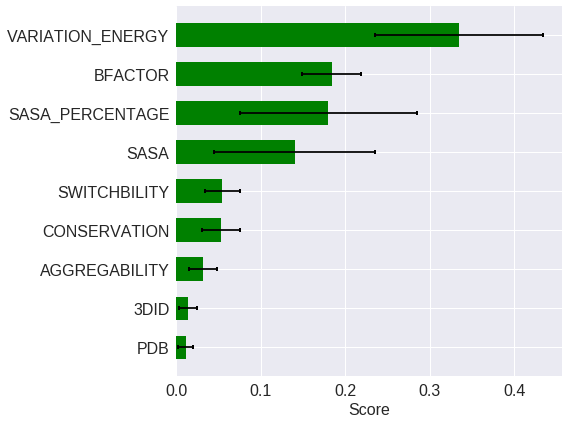

In [86]:
cols = (cont_vars + cat_vars)
ranking_size = 10
forest = rf.steps[1][1]

importances = [(cols[e], x) for e, x in enumerate(forest.feature_importances_)]
importances.sort(key=operator.itemgetter(1), reverse=True)
indices = np.argsort(forest.feature_importances_)[:ranking_size]
importances = importances[:ranking_size][::-1]
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
plt.figure(figsize=(8,6))
plt.barh(np.arange(len(importances)), [y for x, y in importances], 0.6, color="green", align="center", 
         xerr=std[indices], ecolor="black", error_kw={"capthick":2, "capsize":2})
plt.yticks(range(len(importances)), [x for x, y in importances], rotation='horizontal', fontsize=16)
plt.xlabel("Score",fontsize=16)
plt.xticks(fontsize=16)
plt.tight_layout()

# plt.savefig("/home/marlan/Desktop/importances_varq.pdf", bbox_inches='tight', pad_inches=0.1)


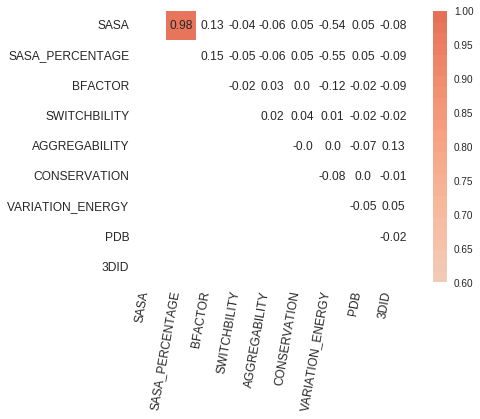

In [114]:
scaled_df = pd.DataFrame(scale[1].fit_transform(impute[1].fit_transform(X)), columns=(cont_vars+cat_vars))
rfpimp.plot_corr_heatmap(scaled_df, figsize=(9,5), label_fontsize=12, value_fontsize=12, save="/home/marlan/Desktop/varq_corrplot.pdf")

In [87]:
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

In [108]:
roc_curve = pd.concat([pd.Series(fpr,name="fpr"), pd.Series(tpr, name="tpr")], axis=1)
roc_curve.to_csv("../results/varq/auc_rf.csv", index=False)

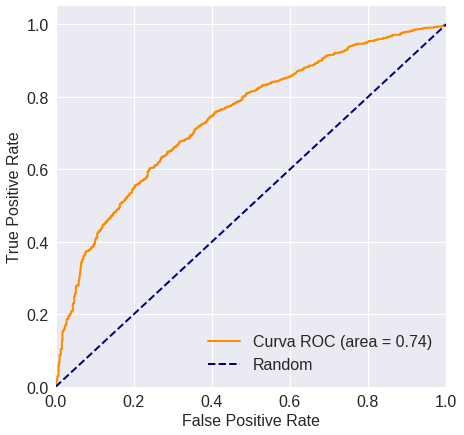

In [89]:
plt.figure(figsize=(7,7))

lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Curva ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.title('AUC Curve')
plt.legend(loc="lower right", prop={'size': 16})

# plt.savefig("/home/marlan/Desktop/auc_varq.pdf", bbox_inches='tight', pad_inches=0.1)

#### Logistic Regression

In [ ]:
folds = 3
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1001)
algorithm = 'lr'
model = Pipeline(model_dict[algorithm]['pipe'])
param_list = [model_dict[algorithm]['params']][0]
gs = GridSearchCV(model, param_list, cv=skf.split(X_train, y_train), n_jobs=2, 
                  scoring='roc_auc', verbose=1, refit=True)

In [ ]:
gs.fit(X_train, y_train)

In [ ]:
lr = gs.best_estimator_

In [ ]:
gs.best_score_

In [ ]:
lr.steps[2]

In [ ]:
importances = list(zip(X_train.columns.tolist(), lr.steps[2][1].coef_[0].tolist()))

In [ ]:
figsize(20,6)
# plt.title("Logistic Regression Coefficients", fontsize=16)
plt.barh(np.arange(len(importances)), [y for x, y in importances], color="g", align="center")
plt.xlabel("Coeficientes", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(range(len(importances)), [x for x, y in importances], rotation='horizontal', fontsize=16)
# plt.xticks(np.arange(-1.1,.7,.05))
plt.show()

#### SVM

In [ ]:
folds = 3
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1001)
algorithm = 'svc'
model = Pipeline(model_dict[algorithm]['pipe'])
param_list = [model_dict[algorithm]['params']][0]
gs = GridSearchCV(model, param_list, cv=skf.split(X_train, y_train), n_jobs=2, 
                  scoring='roc_auc', verbose=1, refit=True)

In [ ]:
X_test.shape

In [ ]:
pd.Series(y_test).value_counts()

In [ ]:
gs.fit(X_train, y_train)

In [ ]:
svc = gs.best_estimator_

In [ ]:
gs.best_score_

In [ ]:
model

In [ ]:
X_train.columns

In [ ]:
print(classification_report(y_test, rf.predict(X_test)))

In [ ]:
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

In [ ]:
fpr.shape

In [ ]:
figsize(7,7)

lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC Curve')
plt.legend(loc="lower right", prop={'size': 12})

plt.savefig("../documents/latex/figures/3/auc_varq.pdf", bbox_inches='tight', pad_inches=0.1)

## Algorithm Comparison

In [ ]:
algos = ["LR", "RF", "SVC"]
aucs = [0.71, 0.74, 0.70]

In [ ]:
plt.rcParams["font.family"] = "DejaVu Sans"

plt.figure(figsize=(10, 4))

barlist = plt.bar(algos, aucs, alpha=0.6)
barlist[0].set_color('mediumaquamarine')
barlist[1].set_color('forestgreen')
barlist[2].set_color('darkmagenta')

for i, rect in enumerate(barlist):
    height = rect.get_height()
    plt.gca().text(rect.get_x() + rect.get_width()/2., 1.05*height, aucs[i], ha='center', va='bottom', fontsize=18)


plt.xticks(fontsize=16)
plt.yticks(np.arange(0,1.1, 0.5), fontsize=18)

# plt.show()
# plt.legend(["AUC"], fontsize=16)

plt.savefig("varq_results.pdf", bbox_inches='tight', pad_inches=0.1)